# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [ ]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
    !mkdir tables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Cumulative Distribution Functions

In [3]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [4]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250
update_binomial(pmf, data)

In [5]:
cumulative = pmf.cumsum()

In [6]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

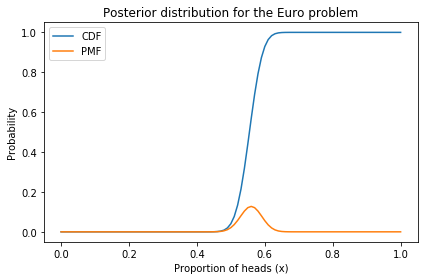

In [7]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')
savefig('fig06-01')

In [8]:
pmf[0.61]

0.034875155909278366

In [9]:
cumulative[0.61]

0.9638303193984253

In [10]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

In [11]:
cdf = pmf.make_cdf()
cdf[0.61]

0.9638303193984253

In [12]:
try:
    cdf[0.615]
except KeyError as e:
    print('KeyError')

KeyError


In [13]:
cdf(0.615)

array(0.96383032)

In [14]:
cdf.quantile(0.9638303)

array(0.61)

In [15]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

## Best Three of Four

In [16]:
def make_die(sides):
    """Pmf that represents a die with the given number of sides.
    
    sides: int
    
    returns: Pmf
    """
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [17]:
def add_dist_seq(seq):
    """Distribution of sum of values from PMFs.
    
    seq: sequence of Pmf objects
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [18]:
die = make_die(6)
dice = [die] * 3

In [19]:
pmf_3d6 = add_dist_seq(dice)

In [20]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

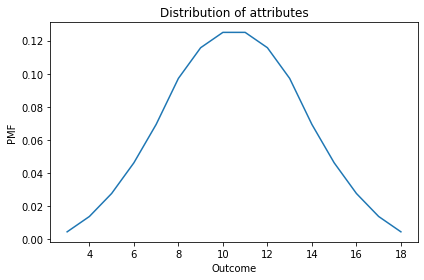

In [21]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

In [22]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))
a.sort(axis=1)
t = a[:, 1:].sum(axis=1)

In [23]:
pmf_4d6 = Pmf.from_seq(t)

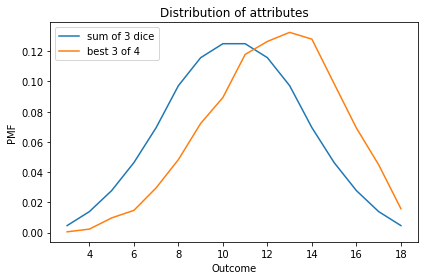

In [24]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_4d6.plot(label='best 3 of 4')

decorate_dice('Distribution of attributes')
savefig('fig06-02')

## Maximum

In [25]:
from empiricaldist import Cdf

cdf_4d6 = pmf_4d6.make_cdf()
cdf_max6 = Cdf(cdf_4d6**6)

In [26]:
pmf_max6 = cdf_max6.make_pmf()

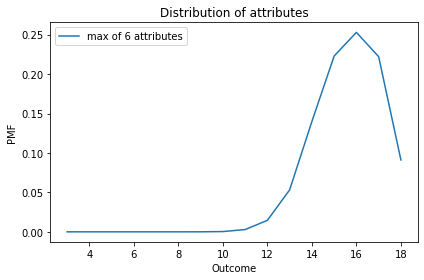

In [27]:
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

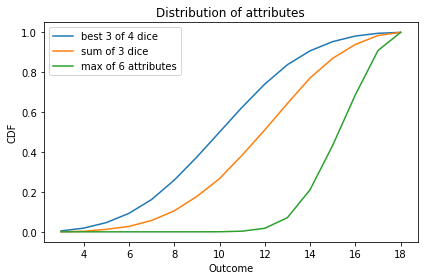

In [28]:
cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='best 3 of 4 dice')

cdf_4d6 = pmf_4d6.make_cdf()
cdf_4d6.plot(label='sum of 3 dice')

cdf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

In [29]:
cdf_max_dist6 = cdf_4d6.max_dist(6)

In [30]:
np.max(np.abs(cdf_max_dist6 - cdf_max6))

0.0

## Minimum

Now let's compute the distribution for the minimum of your six attributes.

Remember that `Cdf(x)` is the probability that a value from the distribution is less than or equal to `x`.

So we can compute the probability that a value is greater than `x`, like this:

In [31]:
prob_gt = 1 - cdf_4d6
prob_gt

3     0.9995
4     0.9972
5     0.9875
6     0.9728
7     0.9432
8     0.8949
9     0.8227
10    0.7333
11    0.6154
12    0.4889
13    0.3564
14    0.2284
15    0.1299
16    0.0607
17    0.0158
18    0.0000
dtype: float64

Now here's the probability that all six values are greater than `x`:

In [32]:
prob_gt6 = prob_gt**6
prob_gt6

3     9.970037e-01
4     9.833172e-01
5     9.273051e-01
6     8.475032e-01
7     7.040812e-01
8     5.136261e-01
9     3.100623e-01
10    1.554856e-01
11    5.431815e-02
12    1.365590e-02
13    2.049397e-03
14    1.419635e-04
15    4.804574e-06
16    5.001867e-08
17    1.555760e-11
18    0.000000e+00
dtype: float64

And finally the probability that all six values are less than or equal to `x`.

In [33]:
prob_le6 = 1-prob_gt6
prob_le6

3     0.002996
4     0.016683
5     0.072695
6     0.152497
7     0.295919
8     0.486374
9     0.689938
10    0.844514
11    0.945682
12    0.986344
13    0.997951
14    0.999858
15    0.999995
16    1.000000
17    1.000000
18    1.000000
dtype: float64

The result is a Pandas Series that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [34]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like.

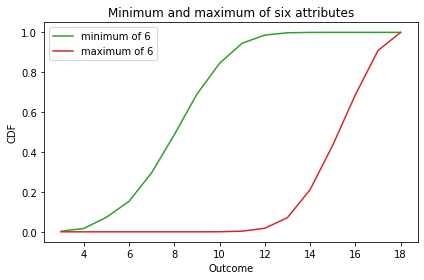

In [35]:
cdf_min6.plot(color='C2', label='minimum of 6')
cdf_max6.plot(color='C3', label='maximum of 6')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF')
savefig('fig06-03')

In [36]:
cdf_min_dist6 = cdf_4d6.min_dist(6)

In [37]:
np.max(np.abs(cdf_min_dist6 - cdf_min6))

0.0

## Mixture

In [38]:
d4 = make_die(4)
d6 = make_die(6)

In [39]:
total = Pmf.add(d4, d6, fill_value=0) / 2
total

1    0.208333
2    0.208333
3    0.208333
4    0.208333
5    0.083333
6    0.083333
dtype: float64

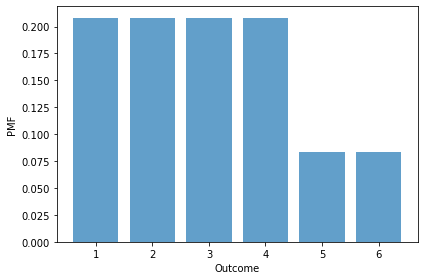

In [40]:
mix = Pmf(total)
mix.bar(alpha=0.7)
decorate_dice()

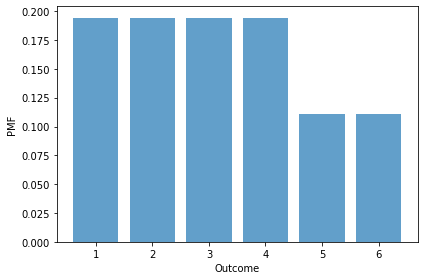

In [41]:
total = Pmf.add(d4, 2*d6, fill_value=0) / 3
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

In [42]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


In [43]:
dice = [make_die(sides) for sides in hypos]

In [44]:
product = dice * pmf_dice.ps
type(product)

numpy.ndarray

In [45]:
type(product[0])

empiricaldist.empiricaldist.Pmf

In [46]:
total = product[0]
for pmf in product[1:]:
    total = Pmf.add(total, pmf, fill_value=0)
    
total

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

In [47]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions.
    
    pmf: mapping from each hypothesis to its probability
    pmf_seq: sequence of Pmfs, each representing 
             a conditional distribution for one hypothesis
    """
    product = pmf_seq * pmf.ps
    total = product[0]
    for each_pmf in product[1:]:
        total = Pmf.add(total, each_pmf, fill_value=0)
    return Pmf(total)

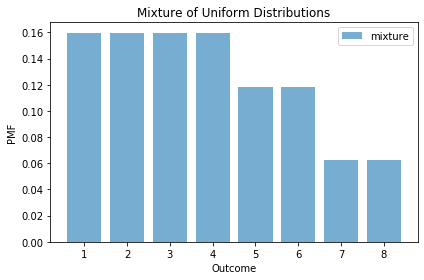

In [48]:
mix = make_mixture(pmf_dice, dice)
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Mixture of Uniform Distributions')
savefig('fig06-04')

In [49]:
mix.sum()

1.0

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.

Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

In [50]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

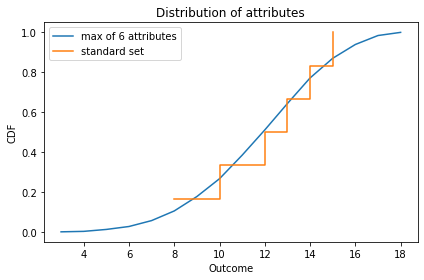

In [51]:
cdf_4d6.plot(label='max of 6 attributes')
cdf_standard.step(label='standard set')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few values.

In [52]:
# Solution

cdf_4d6.mean(), cdf_standard.mean()

(12.246599999999999, 12.0)

In [53]:
# Solution

cdf_4d6.std(), cdf_standard.std()

(2.8458721756256025, 2.3804761428476167)

In [54]:
# Solution

cdf_4d6.lt_dist(8)

0.0568

In [55]:
# Solution

cdf_4d6.gt_dist(15)

0.12990000000000002

In [56]:
# Solution

cdf_min6.lt_dist(8), 1 - (1-cdf_4d6.lt_dist(8))**6

(0.2959187929504574, 0.2959187929504574)

In [57]:
# Solution

cdf_max6.gt_dist(15), 1 - (1-cdf_4d6.gt_dist(15))**6

(0.5660746604907674, 0.5660746604907674)

**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fabricated, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued the practice of weighing his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

In [58]:
mean = 950
std = 50
sample = np.random.normal(mean, std, size=365)

In [59]:
# Solution

cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 975.8110519917371
3 989.0784940961144
4 997.481964456866
5 1003.503119591167


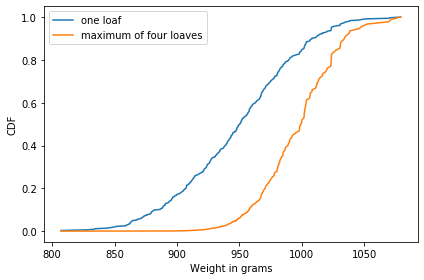

In [60]:
# Solution

cdf.plot(label='one loaf')
cdf.max_dist(4).plot(label='maximum of four loaves')

decorate(xlabel='Weight in grams',
         ylabel='CDF')

**Exercise:**  Suppose I have two boxes of dice:

* One contains a 4-sided die and a 6-sided die.

* The other contains a 6-sided die and an 8-sided die.

I choose a box at random, choose a die, and roll it 3 times.  If I get 2, 4, and 6, which box do you think I chose?

In [61]:
# Solution

d4 = make_die(4)
d6 = make_die(6)
d8 = make_die(8)

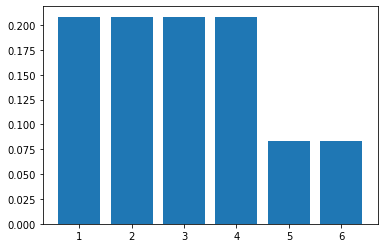

In [62]:
# Solution

pmf1 = Pmf(1/2, [4, 6])
mix1 = make_mixture(pmf1, [d4, d6])
mix1.bar()

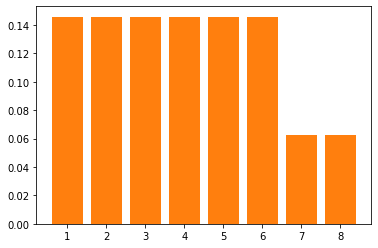

In [63]:
# Solution

pmf2 = Pmf(1/2, [6, 8])
mix2 = make_mixture(pmf2, [d6, d8])
mix2.bar(color='C1')

In [64]:
# Solution

data = [2, 4, 6]
mix1(data)

array([0.20833333, 0.20833333, 0.08333333])

In [65]:
# Solution

mix2(data)

array([0.14583333, 0.14583333, 0.14583333])

In [66]:
# Solution

likelihood = [mix1(data).prod(), mix2(data).prod()]
likelihood

[0.0036168981481481473, 0.003101490162037036]

In [67]:
# Solution

prior = Pmf(1/2, ['Box 1', 'Box 2'])
posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
Box 1,0.538358
Box 2,0.461642


**Exercise:** Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
I choose one of the dice at random, roll it, and report that the outcome is a 1.
If I roll the same die again, what is the probability that I get another 1?

Hint: Compute the posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

In [68]:
# Solution

hypos = [6, 8, 12]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


In [69]:
# Solution

d6 = make_die(6)
d8 = make_die(8)
d12 = make_die(12)

dice = d6, d8, d12

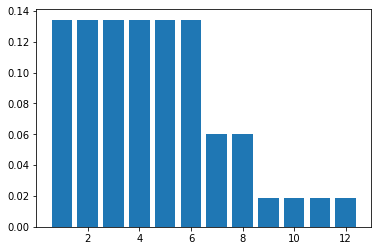

In [70]:
# Solution

mix = make_mixture(posterior, dice)
mix.bar()

In [71]:
# Solution

mix[1]

0.13425925925925924